# Bigram Language Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/nn/01-bigrams.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

## Introduction

In this notebook, we introduce a **character-level** language model. This model can be used to generate new names using a Markov process from a dataset of names. Our focus will be on introducing the overall framework of language modeling that includes probabilistic modeling and optimization. This includes deciding on a model architecture, model training and evaluation using a loss function. Here we use the negative log-likelihood for classification. We will also introduce a sampling method based on the learned conditional probability distribution over the characters. In particular, we will model probabilities of **bigrams** by counting and by using a simple neural network with a single hidden layer. This notebook is based on the lecture {cite}`makemore1`.

## Preliminaries

In [1]:
import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Downloading the dataset of names that we will model:

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
print(len(names))
names[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Names as sequences

A name is simply a sequence of characters. The primary task of **language modeling** is to assign probabilities to sequences. Recall that we can write a joint distribution as a chain of conditional distributions:

$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_n) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 1}^{n-1} p(\boldsymbol{\mathsf x}_{t+1} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t}).
$$

In practice, since distributions conditioned on sequences of different sizes are difficult to learn, we condition on a **context** consisting of previous characters $(\boldsymbol{\mathsf x}_{t-k+1}, \ldots, \boldsymbol{\mathsf x}_{t})$ of fixed size $k$ to approximate the conditional probability of $\boldsymbol{\mathsf x}_{t+1}.$ For example, we can create input-output pairs for the name `olivia` with context size 2: 

```
ol -> i
li -> v
iv -> a
``` 

These are also called **trigrams**. For context size 1, the pairs are called **bigrams**. In this notebook we will focus on bigrams, i.e. predicting the next character using a single character as context. And maybe look at how results improve by using trigrams which uses a larger context. 

### Padding

Because our names are not infinite sequences, we also want to model the start and end of names. We do this by introducing special characters for them and incorporating these into the dataset. For example:

```
[o -> l
li -> v
iv -> a
va -> ]
```

This way our models also learn how to start and end names. But observe that it suffices to use a single character `.` to indicate the start and end of a name. Sort of like a record button is pressed twice to record the characters.

```
.. -> o
ol -> i
li -> v
iv -> a
va -> .
```

Note that we use two dots (i.e. equal to the number of context) since we want the model to start from nothing to the first character.

### Dataset builder

From the discussion above, we want to sample input-output pairs of each character and its context from names to model the conditional probabilities. This is implemented by the following class which builds all subsequences of characters $(\boldsymbol{\mathsf x}_{t-k+1}, \ldots,\boldsymbol{\mathsf x}_{t})$ of a name as input and the next character $\boldsymbol{\mathsf x}_{t+1}$ as the corresponding target to form our character-level dataset. 

In [3]:
from itertools import product
from string import ascii_lowercase

class CharDataset:
    def __init__(self, names, block_size):
        self.names = names
        self.block_size = block_size
        self.chars = ['.'] + list(ascii_lowercase)
        self.words = map(lambda c: ''.join(c), product(self.chars, repeat=block_size))
        self.itos = {i: c for i, c in enumerate(self.chars)}
        self.stoi = {c: i for i, c in self.itos.items()}
        self._decoder = {i: w for i, w in enumerate(self.words)}
        self._encoder = {w: i for i, w in self._decoder.items()}
        
    def decode(self, x):
        return self._decoder[x]

    def encode(self, word):
        return self._encoder[word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        return xs, ys

Using this we can create sequence datasets of arbitrary context size.

### Encoding bigrams

Recall that we have to define an encoding function which maps to words to its numerical representation to use the dataset builder. For our purposes, we simply map each word to integers. Note that this encoding will have a large effect on the models that we will build (i.e. we only get to learn lookup tables).

In [4]:
bigrams = CharDataset(names, block_size=1)

# Character maps global
itos = bigrams.itos
stoi = bigrams.stoi

print(bigrams.encode('.'), bigrams.encode('a'), bigrams.encode('b'))
print(bigrams.decode(0), bigrams.decode(1), bigrams.decode(2))

0 1 2
. a b


For comparison, we also build a dataset for trigrams:

In [5]:
trigrams = CharDataset(names, block_size=2)
print(trigrams.encode('..'), trigrams.encode('.a'), trigrams.encode('zz'))
print(trigrams.decode(0), trigrams.decode(1), trigrams.decode(728))

0 1 728
.. .a zz


Building the dataset for trigrams:

In [6]:
import pandas as pd

xs, ys = trigrams.build_dataset()

df = pd.DataFrame({'xs': xs, 'ys': ys})
df['seq'] = df['xs'].apply(trigrams.decode)
df['target'] = df['ys'].map(trigrams.itos)
df.head(12)

,xs,ys,seq,target
0,0,5,..,e
1,5,13,.e,m
2,148,13,em,m
3,364,1,mm,a
4,352,0,ma,.
5,0,15,..,o
6,15,12,.o,l
7,417,9,ol,i
8,333,22,li,v
9,265,9,iv,i


## Counting bigrams

To structure the data better, we use a 2D array. An entry `[i, j]` in this array is the count of bigrams that start with the `i`th character followed by the `j`th character. Recall that we use `.` to signify the start of a name which will be closed by another `.` to signify its end. Iterating over all names to get all existing bigrams:

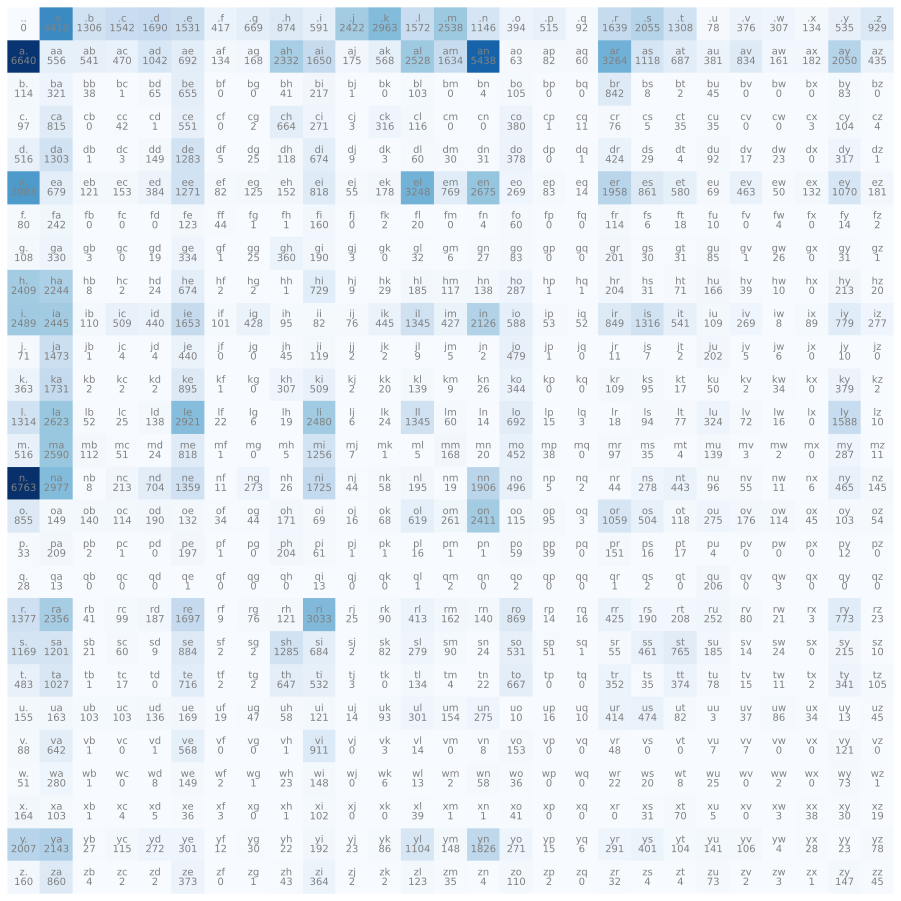

In [7]:
import torch

xs, ys = bigrams.build_dataset() # bigrams == block_size=1

# Create count matrix
N2 = torch.zeros((27, 27), dtype=torch.int32)
for x, y in zip(xs, ys):
    N2[x, y] += 1

# Visualize count matrix
plt.figure(figsize=(16, 16))
plt.imshow(N2, cmap='Blues')
for x in range(N2.shape[0]):
    for y in range(N2.shape[1]):
        chstr = bigrams.itos[x] + bigrams.itos[y]
        plt.text(y, x, chstr, ha="center", va="bottom", color='gray')
        plt.text(y, x, N2[x, y].item(), ha="center", va="top", color='gray')

plt.axis('off');

### Generating names

Already at this point we can generate names. Recall that we can write joint distributions as a chain of conditional probabilities. But that we condition only on limited context as a form of truncation or approximation. This process can also used as an algorithm to generate names. 

First, a character is sampled given the start context (i.e. `..` for trigrams). The context shifts by appending it with the last sampled character to sample a new one. For example, we adjust the context to `.e` after sampling `e` from `..`. This is repeated until we sample another `.` which indicates the end of a name.

In [8]:
def generate_names(P, dataset, sample_size, seed=2147483647):
    """Generate names from a Markov process with cond probability table P."""

    g = torch.Generator().manual_seed(seed)
    block_size = dataset.block_size
    names = []
    for _ in range(sample_size):
        out = []
        context = '.' * block_size
        while True:
            i = dataset.encode(context)
            j = torch.multinomial(P[i], num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + dataset.itos[j]
            out.append(dataset.itos[j])
        names.append(''.join(out))
    return names

Generating names from conditional distributions estimated by counting bigrams:

In [9]:
P2 = N2 / N2.sum(dim=1, keepdim=True)
for name in generate_names(P2, bigrams, sample_size=12, seed=0):
    print(name)

ynawirahaelahelelann
mamameniaria
jrikon
areles
zrn
cyn
ki
li
bylais
roreo
da
kaceiailielakou


Trying out trigrams:

In [10]:
xs, ys = trigrams.build_dataset()

N3 = torch.zeros((27*27, 27), dtype=torch.int32)
for x, y in zip(xs, ys):
    N3[x, y] += 1

P3 = N3 / N3.sum(dim=1, keepdim=True)
for name in generate_names(P3, trigrams, sample_size=12, seed=0):
    print(name)

yonslyaana
bilie
chmaraidener
rmadevenna
arifer
zurecyn
ki
li
by
bliannian
dachaeleah
lel


Note that modeling using bigrams is pretty bad. But it still looks better than random. Trigrams improve a tiny bit. One reason this is bad is that the next most probable bigram has probability that drops exponentially from the last. This is known as [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law). Interestingly, this empirical law holds even for trigrams, and even for [word-level language models](https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html#exploratory-language-statistics).

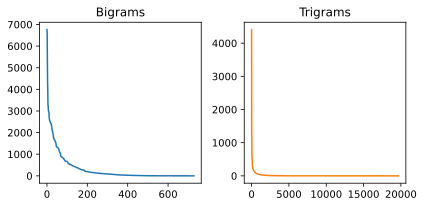

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(sorted(N2.reshape(-1), reverse=True))
ax[1].plot(sorted(N3.reshape(-1), reverse=True), color='C1')
ax[0].set_title('Bigrams')
ax[1].set_title('Trigrams')
fig.tight_layout()

### Model quality: MLE = NLL

To measure model quality we use [maximum likelihood estimation](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#the-maximum-likelihood-principle) (MLE). That is, we choose model parameters $\boldsymbol{\Theta}$ that maximizes the probability of the dataset. For our character-level language model, our objective will be to maximize the probability assigned by the model to the next character:

$$
\hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}).
$$

From the perspective of optimization, it is better to take the negative logarithm of the probability which is a positive function that increases rapidly as the probability goes to zero, and has a nonzero derivative even as the probability goes to 1. Hence, we take the resulting loss function called the **negative log-likelihood** which is equivalent to next-character MLE, but easier to optimize:

$$
\mathcal{L}(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{\boldsymbol{\mathsf{x}}} \sum_t -\log\, \hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta})
$$

where $n$ is the total number of characters to predict. Let us compute the NLL of the bigram model after fitting it on the counts. Note that bigram models assign probability using only the previous character, so that $\,\hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}) = f(\boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}).$ 

In [12]:
class BigramModel:
    def __init__(self):
        """
        Sequence model that uses bigrams / Markov process 
        for estimating probability of next char: P(b | a).
        """
        self.P = None  # cond. prob
        self.N = None  # counts

    def __call__(self, x: int) -> list[float]:
        return torch.tensor([self.P[x, y] for y in range(27)])

    def fit(self, xs, ys):
        self.N = torch.zeros((27, 27), dtype=torch.int32)
        for x, y in zip(xs, ys):
            self.N[x, y] += 1

        self.P = self.N / self.N.sum(dim=1, keepdim=True)

Training the model on input and target sequences:

In [13]:
xs, ys = bigrams.build_dataset()

# Fitting the bigram model
bigram_model = BigramModel()
bigram_model.fit(xs, ys)

Computing the NLL of the bigram model:

In [14]:
log_likelihood = 0.0
n = 0
for x, y in zip(xs, ys):
    p = bigram_model(x)[y]
    log_p = torch.log(p)
    log_likelihood += log_p
    n += 1
    if n < 12:
        print(f'p({itos[y]}|{itos[x]})={p:.4f}    nll={-log_p:.4f}')

nll = -log_likelihood
print('...')
print(f"nll = {nll / n:.4f} (overall)")

p(e|.)=0.0478    nll=3.0408
p(m|e)=0.0377    nll=3.2793
p(m|m)=0.0253    nll=3.6772
p(a|m)=0.3899    nll=0.9418
p(.|a)=0.1960    nll=1.6299
p(o|.)=0.0123    nll=4.3982
p(l|o)=0.0780    nll=2.5508
p(i|l)=0.1777    nll=1.7278
p(v|i)=0.0152    nll=4.1867
p(i|v)=0.3541    nll=1.0383
p(a|i)=0.1381    nll=1.9796
...
nll = 2.4541 (overall)


A model that assigns a probability of `1.0` for each next actual character has a perfect NLL of exactly `0.0`. Here our bigram model gets penalized for next characters whose bigrams from the previous character occurs rarely on the training dataset.

### Smoothing

Note that the loss can result in `+inf` when this encounters a bigram with zero counts in the training data, e.g. the name `gopde` since the bigram `pd` never appears on the training data. One way to fix this is to perform **model smoothing**. This can be done by adding a fixed constant to the counts:

```python
a = 2
P = (N + a).float() / (N + a).sum(dim=1, keepdim=True)
```

The larger the constant `a`, the more uniform the resulting probabilities are. Hence, the term smoothing. 

## Modeling probabilities

A neural network layer typically involves multiplication between the input vector and the weights matrix. So we design our neural network to have a single layer with weights $\boldsymbol{\mathsf W}$ of size `(27, 27)` that corresponds to the count matrix above. The relevant row of weights is picked out by computing $\boldsymbol{\mathsf w}_a = \boldsymbol{\mathsf x}_a \boldsymbol{\mathsf W}$ where $\boldsymbol{\mathsf x}_a$ is the one-hot encoding of the input character $a.$ Then, we apply softmax to $\boldsymbol{\mathsf w}_a$ which is a common technique for converting real-valued vectors to probabilities.

This model still uses bigrams, but the assignment of conditional probabilities is estimated by initializing random weights which are fine-tuned using gradient descent such that the probabilities of the actual next characters are maximized.

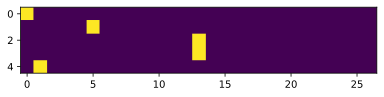

In [15]:
import torch.nn.functional as F

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xenc = F.one_hot(xs, num_classes=27).float() # convert to float
plt.imshow(xenc[:5, :]); # 0, 5, 13, 13, 1, ...

In [16]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

probs = F.softmax(xenc @ W)
probs.shape

torch.Size([228146, 27])

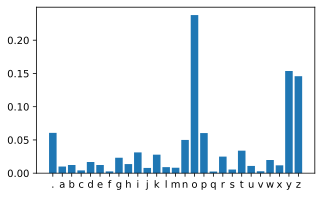

In [17]:
plt.figure(figsize=(5, 3))
plt.bar(stoi.keys(), probs[0].data);

Observe that the weights with values in `(-inf, +inf)` can be interpreted as **log-counts** of bigrams that start on the row index. This is interesting because growth in the negative direction is different from growth in the positive direction. Applying `.exp()` we get units of count with values in `(0, +inf)`. These values are normalized to get an output vector with values in `(0, 1)` which we interpret as a probability distribution. Training the network will make these interpretations valid. This is implemented as follows:

In [18]:
class NNBigramModel:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ self.W                         # init => log-counts
        counts = logits.exp()                          # .exp() => counts
        probs = counts / counts.sum(1, keepdim=True)   # normalizing => probability
        return probs
        
    def zero_grad(self):
        self.W.grad = None


```{figure} ../../img/bigram-nn.drawio.svg
---
width: 450px
name: bigram-nn.drawio
---

Schematic diagram of the bigram neural net. Computing the probability assigned by the model on `b` given `a` which is represented here as one-hot vector. Note that this is also the backward dependence for a bigram `ab` encountered during training with the NLL loss.
```

**Remark.** Note that the output of the model is specified by 729 numbers, i.e. one distribution over the characters for each character. This is a pretty weak model (essentially a lookup table). What will change with further networks is how to compute and assign probabilities to the next character. This will require more complex neural network architecture that reflect a different prior for the character dependencies.

### Model training

This should converge to a similar loss value as the bigram counting model (same capacity):

In [19]:
model = NNBigramModel()

losses = []
num_steps = 100
for k in range(num_steps):
    probs = model(xs)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()  # next char nll

    model.zero_grad()
    loss.backward()
    model.W.data -= 100.0 * model.W.grad
    
    # logging
    losses.append(loss.item())
    if k % 10 == 9:
        print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

[010/100]   loss=2.6075
[020/100]   loss=2.5346
[030/100]   loss=2.5162
[040/100]   loss=2.5025
[050/100]   loss=2.5004
[060/100]   loss=2.4930
[070/100]   loss=2.4942
[080/100]   loss=2.4887
[090/100]   loss=2.4910
[100/100]   loss=2.4863


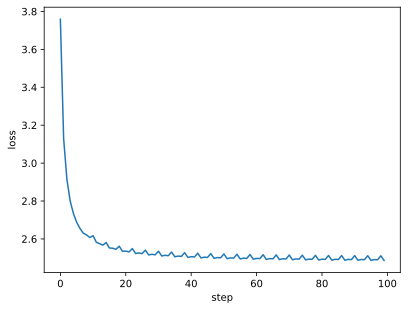

In [20]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('step');

### Sampling

Generating names and its associated NLL:

In [21]:
counts = model.W.exp()
P2_nn = (counts / counts.sum(dim=1, keepdim=True)).data

def name_loss(name, P, dataset):
    nll = 0.0
    context = '.' * dataset.block_size
    for c in name + '.':
        p = P[dataset.encode(context), dataset.stoi[c]]
        nll += -math.log(p)
        context = context[1:] + c
    return nll / (len(name) + 1)


sample = generate_names(P2_nn, bigrams, sample_size=12, seed=0)
name_losses = {n: name_loss(n, P2_nn, bigrams) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")

an                     1.692
kaninnariaelyleree     2.026
nah                    2.139
li                     2.235
ynduroddeelalikelannan 2.348
daffahalamenanamou     2.438
m                      2.552
kerdaqavaven           2.791
zsolazlemi             2.876
mgaynelyhyohigh        2.955
bziamoaroreo           2.957
omelu                  3.095


Recall that instead of maximizing names, we are maximizing next character likelihood. This explains why we can get short names such as `'nah'` and long names `'kaninnariaelyleree'` with low NLL even if these seem unlikely to occur naturally as names. Consequently, it should be rare that a generated name is in the training dataset:

In [22]:
print(r"Generated names in training dataset:")
sample_size = 10000
print(f"{100 * sum([n in names for n in generate_names(P2_nn, bigrams, sample_size=sample_size)]) / sample_size}% (sample_size={sample_size})")

Generated names in training dataset:
8.03% (sample_size=10000)


Let us look at the model's learned weights. Conditional distributions are easier to visualize:

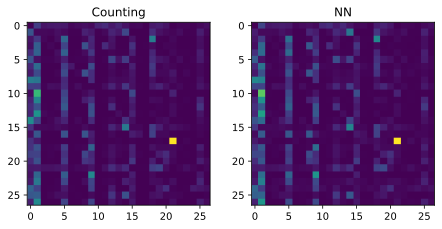

In [23]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()

ax[0].imshow(P2)
ax[0].set_title("Counting")
ax[1].imshow(P2_nn)
ax[1].set_title("NN");

It looks like the neural net recovered something very similar to the true count matrix! This explains why the two models generated very similar set of names.

### Regularization

Observe that smoothing the count matrix approximates to it having constant entries. In the context of the neural net model, this means having a zero weight matrix so that the resulting count matrix `W.exp()` is a matrix of ones. The more getting zero weights is incentivized in the loss function, the more uniform the resulting distribution is. This is precisely weight **regularization**. For example, we can add $\frac{\alpha}{n}\lVert \boldsymbol{\mathsf W} \rVert^2_2$ where $n = |\boldsymbol{\mathsf W}|$ to the loss function:

```python
loss += 0.1 * model.W.square().mean()
```

Notice that regularization acts like a force that pushes the weights to zero, whenever its magnitude increases to try to reduce the original NLL loss which depends on the training dataset. This also results in weights being smoothed out since the penalty grows quadratically in magnitude.

**Remarks.** Regularization is sometimes called **weight decay** which makes sense since the gradient of the regularization term literally just decays the weight. As such, weight decay should only be applied to weights (e.g. not to biases or embeddings), so that network expressivity is not too strongly limited. This is also why regularization is only beneficial if the network overfits, otherwise it can hurt the model.

## Appendix: Trigrams

In this section, we train a trigram language model, i.e. taking two characters as an input to predict the 3rd one. Let us see if it improves over a bigram model. This is straightforward to implement with a weight matrix of shape `(729, 27)` one row for each pair.

In [24]:
from itertools import product

xs, ys = trigrams.build_dataset()
xs = torch.tensor(xs)
ys = torch.tensor(ys)

for i in range(5):
    print(f"{trigrams.decode(xs[i].item())}  ->  {itos[ys[i].item()]}")

..  ->  e
.e  ->  m
em  ->  m
mm  ->  a
ma  ->  .


### Implementation

Trigram model just has more input neurons in its hidden layer:

In [25]:
class TrigramModel:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27*27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        xenc = F.one_hot(xs, num_classes=27*27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        return probs
        
    def zero_grad(self):
        self.W.grad = None

Model training:

In [26]:
def optim_step(model, lr):
    model.W.data -= lr * model.W.grad

def train_model(model, xs, ys, num_steps=100, lr=100.0):
    losses = []
    for k in range(num_steps):
        probs = model(xs)
        loss = -probs[torch.arange(len(ys)), ys].log().mean()

        model.zero_grad()
        loss.backward()
        optim_step(model, lr)

        # logging
        losses.append(loss.item())
        if k % 10 == 9:
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

    return losses


model = TrigramModel()
train_model(model, xs, ys);

[010/100]   loss=2.9982
[020/100]   loss=2.7574
[030/100]   loss=2.6386
[040/100]   loss=2.5644
[050/100]   loss=2.5123
[060/100]   loss=2.4733
[070/100]   loss=2.4431
[080/100]   loss=2.4190
[090/100]   loss=2.3992
[100/100]   loss=2.3827


### Training with validation

Modifying our training function to support testing and validation:

In [27]:
def nll_loss(model, xs, ys):
    probs = model(xs)
    n = len(ys)
    return -probs[torch.arange(n), ys].log().mean()


def train_model(
        model, 
        xs, ys, 
        xs_valid, ys_valid, 
        xs_infer, ys_infer,
        num_steps=100, 
        lr=100.0,
        loss_fn=nll_loss,
        eval_fn=None,
        verbose=True
    ):
    
    if eval_fn is None:
        eval_fn = loss_fn

    losses_train = {}
    losses_valid = {}

    for k in range(num_steps):
        loss = loss_fn(model, xs, ys)

        model.zero_grad()
        loss.backward()
        optim_step(model, lr)

        # logging
        losses_train[k] = loss.item()
        with torch.no_grad():
            loss_valid = eval_fn(model, xs_valid, ys_valid).item()
            losses_valid[k] = loss_valid

        if verbose and (k % 10 == 9):        
            print(f"[{k+1:>03d}/{num_steps}]    loss={loss:.4f}    dev_loss={loss_valid:.4f}")
    
    loss_infer = eval_fn(model, xs_infer, ys_infer).item()
    loss_valid = eval_fn(model, xs_valid, ys_valid).item()
    if verbose:
        print(f'test_loss={loss_infer:.4f}')
    
    return {"loss_train": losses_train, "loss_valid": losses_valid, "loss_infer": loss_infer}

Since our approach is to predict next characters, we want to stratify based on a balanced distribution of next characters over the splits.

In [28]:
from sklearn.model_selection import StratifiedKFold

def create_folds(xs, ys, seed=42):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros_like(xs)
    for fold, (trn_, val_) in enumerate(kf.split(xs, ys)):
        folds[val_] = fold

    xs_train, ys_train = xs[folds >  1], ys[folds >  1]
    xs_valid, ys_valid = xs[folds == 1], ys[folds == 1]
    xs_infer, ys_infer = xs[folds == 0], ys[folds == 0]

    return xs_train, ys_train, xs_valid, ys_valid, xs_infer, ys_infer

Let us look at the previous bigram NN model. 

In [29]:
xs_, ys_ = bigrams.build_dataset()
xs_ = torch.tensor(xs_)
ys_ = torch.tensor(ys_)

print("Bigram model training:")
hist_bigram = train_model(
    NNBigramModel(), 
    *create_folds(xs_, ys_)
)

Bigram model training:
[010/100]    loss=2.6099    dev_loss=2.6046
[020/100]    loss=2.5352    dev_loss=2.5258
[030/100]    loss=2.5170    dev_loss=2.5255
[040/100]    loss=2.5033    dev_loss=2.4971
[050/100]    loss=2.5013    dev_loss=2.5111
[060/100]    loss=2.4939    dev_loss=2.4880
[070/100]    loss=2.4951    dev_loss=2.5053
[080/100]    loss=2.4895    dev_loss=2.4838
[090/100]    loss=2.4919    dev_loss=2.5022
[100/100]    loss=2.4871    dev_loss=2.4815
test_loss=2.4920


Comparing this with the trigram model:

In [30]:
xs, ys = trigrams.build_dataset()
xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs_train, ys_train, \
xs_valid, ys_valid, \
xs_infer, ys_infer = create_folds(xs, ys)

print("Trigram model training:")
hist_trigram = train_model(
    TrigramModel(),
    xs_train, ys_train, 
    xs_valid, ys_valid, 
    xs_infer, ys_infer
)

Trigram model training:
[010/100]    loss=2.9966    dev_loss=2.9674
[020/100]    loss=2.7558    dev_loss=2.7458
[030/100]    loss=2.6372    dev_loss=2.6335
[040/100]    loss=2.5632    dev_loss=2.5623
[050/100]    loss=2.5112    dev_loss=2.5119
[060/100]    loss=2.4724    dev_loss=2.4740
[070/100]    loss=2.4422    dev_loss=2.4445
[080/100]    loss=2.4180    dev_loss=2.4208
[090/100]    loss=2.3982    dev_loss=2.4014
[100/100]    loss=2.3817    dev_loss=2.3852
test_loss=2.4003


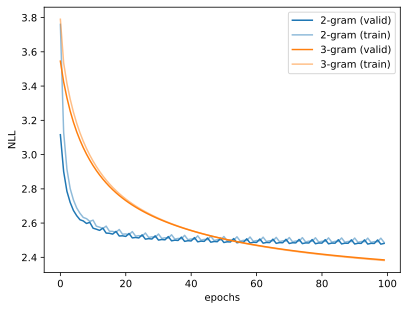

In [31]:
plt.plot(hist_bigram ['loss_valid'].keys(), hist_bigram ['loss_valid'].values(), color=f'C0', label="2-gram (valid)")
plt.plot(hist_bigram ['loss_train'].keys(), hist_bigram ['loss_train'].values(), color=f'C0', label="2-gram (train)", alpha=0.5)

plt.plot(hist_trigram['loss_valid'].keys(), hist_trigram['loss_valid'].values(), color=f'C1', label="3-gram (valid)")
plt.plot(hist_trigram['loss_train'].keys(), hist_trigram['loss_train'].values(), color=f'C1', label="3-gram (train)", alpha=0.5)

plt.ylabel('NLL')
plt.xlabel('epochs')
plt.legend();

Using trigrams seem to result in better generalization. This can be expected since trigrams include more context (i.e. one more character) to predict the next word. Although, the trigram model is more difficult to train as it requires learning 27³ probabilities. Indeed, we see from the loss curves that the trigram model converges more slowly!

### Using cross-entropy loss

Our 1-hot vectors merely select a row of `W`, so producing these vectors explicitly feels wasteful. The use of `F.one_hot` can be avoided in favor of simply indexing into rows of `W`. Fortunately, this operation is differentiable. Another thing we will change is to use `F.cross_entropy`. This should achieve the same result.

In [32]:
class TrigramModelEfficient:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27*27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        logits = self.W[xs]
        return logits
        
    def zero_grad(self):
        self.W.grad = None


def cross_entropy_loss(model, xs, ys):
    return F.cross_entropy(model(xs), ys)


trigram_model = TrigramModelEfficient()
train_model(
    trigram_model, 
    xs_train, ys_train, 
    xs_valid, ys_valid, 
    xs_infer, ys_infer,
    loss_fn=cross_entropy_loss,
);

[010/100]    loss=2.9966    dev_loss=2.9674
[020/100]    loss=2.7558    dev_loss=2.7458
[030/100]    loss=2.6372    dev_loss=2.6335
[040/100]    loss=2.5632    dev_loss=2.5623
[050/100]    loss=2.5112    dev_loss=2.5119
[060/100]    loss=2.4724    dev_loss=2.4740
[070/100]    loss=2.4422    dev_loss=2.4445
[080/100]    loss=2.4180    dev_loss=2.4208
[090/100]    loss=2.3982    dev_loss=2.4014
[100/100]    loss=2.3817    dev_loss=2.3852
test_loss=2.4003


This is precisely the same results as in the implementation of the trigram model above. This also shows that applying `F.cross_entropy` to the logits is equivalent to NLL with softmax probabilities. But this is super fast: 10x faster than the previous implementation. Also, using cross-entropy loss on logits is more numerically stable. Observe that with a softmax layer, we can add any constant to the logits without affecting the result. Hence, we can subtract the largest logit ${\mathsf s}_{j^*}$ so that the largest exponential is 1, avoiding overflow (even if other terms underflow):

$$
\begin{aligned}
\log \left( \frac {e^{\mathsf s_i}}{\sum_{j} e^{\mathsf s_j}} \right) 
&= {\mathsf s}_i - \log \left( {\sum_{j} e^{\mathsf s_j}} \right) \\
&= {\mathsf s}_i - {\mathsf s}_{j^*} - \log \left( \sum_{j} e^{{\mathsf s}_j - {\mathsf s}_{j^*}} \right).
\end{aligned}$$

Note that directly using this formula and the corresponding formula for backward results to faster forward and backward passes (e.g. reducing the number of nodes to traverse when constructing gradients). Observe also that division is avoided and that only the target index of the softmax has to be computed by `F.cross_entropy`. This makes training more efficient.

In [33]:
bad_logits = torch.tensor([100., 20., 1., -200])
probs = bad_logits.exp() / bad_logits.exp().sum()
print(probs.numpy())

probs = (bad_logits - 100).exp() / (bad_logits - 100).exp().sum()
print(probs.numpy())

[nan  0.  0.  0.]
[1.0000000e+00 1.8048513e-35 1.0089349e-43 0.0000000e+00]


On the other hand, `F.cross_entropy` just works:

In [34]:
F.cross_entropy(bad_logits, target=torch.tensor(0))

tensor(0.)

### Strength of regularization

Here we will tune the strength of smoothing (or regularization) for the trigram model. Note that we still use the (unregularized) NLL loss for evaluation.

alpha=1.00e-03    nll_valid=2.3852    nll_infer=2.4003
alpha=1.00e-02    nll_valid=2.3851    nll_infer=2.4001
alpha=1.00e-01    nll_valid=2.3844    nll_infer=2.3993
alpha=1.00e+00    nll_valid=2.4256    nll_infer=2.4391
alpha=1.00e+01    nll_valid=2.7945    nll_infer=2.8024
alpha=1.00e+02    nll_valid=3.1998    nll_infer=3.2009


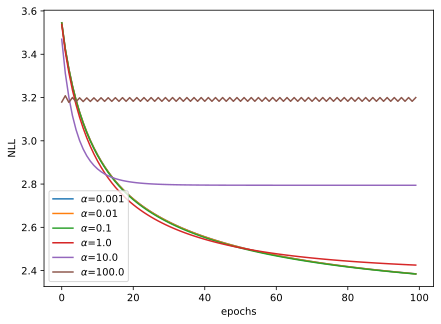

In [35]:
from functools import partial

def regularized_ce_loss(model, xs, ys, alpha):
    loss = cross_entropy_loss(model, xs, ys)
    reg = alpha * model.W.square().mean()
    return loss + reg
    

plt.figure(figsize=(7, 5))
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0]):
    model = TrigramModelEfficient()
    history = train_model(
        model, 
        xs_train, ys_train, 
        xs_valid, ys_valid, 
        xs_infer, ys_infer,
        loss_fn=partial(regularized_ce_loss, alpha=alpha),
        eval_fn=cross_entropy_loss,
        verbose=False
    )
    plt.plot(history['loss_valid'].keys(), history['loss_valid'].values(), color=f'C{i}', label=r'$\alpha$='+f"{alpha}")
    print(f"alpha={alpha:.2e}    nll_valid={cross_entropy_loss(model, xs_valid, ys_valid):.4f}    nll_infer={history['loss_infer']:.4f}") # Not including reg.
    
plt.ylabel('NLL')
plt.xlabel('epochs')
plt.legend();

As discussed above, the stronger the regularization, the more uniform the output distributions become. More precisely, we get near zero logits values, which results in a uniform distribution under the softmax ($e^\delta \approx 1$ for $|\delta| \ll 1$). Indeed, we see in the plot that the valid loss converges to worse values as we increase $\alpha$ which controls the strength of regularization. The curves approach the NLL for a model that assigns the same probability to all ${n}$ characters: $-\log \frac{1}{{n}} = \log {n}.$

In [36]:
math.log(27.0)

3.295836866004329